# Import Library

In [1]:
# 导入各种模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics
import glob
import csv
import os
% matplotlib inline
from keras_self_attention import SeqSelfAttention
import warnings

# 忽略警告级别的消息
warnings.filterwarnings('ignore')

# 检查TF是否能用GPU加速
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
# 设置数据目录
interesting_dir = "./Data/Fastest/"
#interesting_files = ["sit.csv", "stand.csv", "walk.csv"]
interesting_labels = ['stand', 'walk', 'jump', 'fall']
save_filename = "activity"

Default GPU Device: /device:GPU:0


# Concate and label the raw data  

In [2]:
def data_concate_label(path, label):
    # path1 = r".\Data\Fastest\stand"
    # label1 = "stand"
    #返回与路径名称匹配的文件列表，这里就是指这个目录下的所有csv文件所在路径的列表。
    all_files1 = glob.glob(path + "/*.csv")

    li = []

    for filename in all_files1:
        # 将每一个csv列表不要索引，用pandas读取为Dataframe文件。
        df = pd.read_csv(filename, index_col=None, header=0)
        # 如果df文件中已经包含了'label'列，则忽略，如果不包含'label'列就将传入的label，
        # 这里第一个传入的是'stand'当做'label'列。
        if 'label' in df.columns:
            pass
        else:
            df['label'] = str(label)
        # 将每个csv读取之后的df文件添加到li列表中
        li.append(df)
    # 将读取的所有数据横向合并，并且去掉索引。
    frame = pd.concat(li, axis=0, ignore_index=True)
    #     frame = frame.drop_duplicates()
    # 如果数据一共有19列，我们就用让new_header等于第一个，否则为第二个。
    if len(df.columns) == 19:
        new_header = ['DATE', 'TIME', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'lx', 'ly', 'lz', 'mx', 'my', 'mz', 'ma',
                      'mg', 'ml', 'mm', 'label']
    else:
        new_header = ['DATE', 'TIME', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'ma', 'mg', 'label']
    #     if label == 'fall':
    #         frame = frame.drop_duplicates()
    #         frame = frame.query("mg >= 10 ")
    #     if label =='jump':
    #         frame = frame.query("mg <= 6")
    #     else : pass
    # 这里只选取前 16000行数据
    frame = frame[:16000]

    print(frame.shape)
    print(len(df.columns))
    # 将合并后的数据保存为csv并且重命名，表头由上面的new_header决定。
    frame.to_csv("./Data/Fastest/activity_" + str(label) + ".csv", index=False, header=new_header)


In [3]:
# 依次设置四个目录的标签和路径然后将其传入data_concate_label函数
path1 = r".\Data\Fastest\stand"
label1 = "stand"
path2 = r".\Data\Fastest\walk_new"
label2 = "walk"
path3 = r".\Data\Fastest\jump"
label3 = "jump"
path4 = r".\Data\Fastest\Fall"
label4 = "fall"
data_concate_label(path1, label1)
data_concate_label(path2, label2)
data_concate_label(path3, label3)
data_concate_label(path4, label4)

(16000, 11)
11
(16000, 11)
11
(16000, 11)
11
(16000, 11)
11


# Concate all data into one .csv file

In [4]:
import copy

# 初始化一个df
df = pd.DataFrame()
# 将刚才的四个csv文件的数据拼接在一起
for i in range(len(interesting_labels)):
    #     df_tmp = pd.read_csv(interesting_dir+save_filename+"_"+str(i+1)+'.csv',parse_dates=[['DATE', ' TIME']],header = 0)
    df_tmp = pd.read_csv(interesting_dir + save_filename + "_" + interesting_labels[i] + '.csv', header=0)
    df = pd.concat([df, df_tmp])

print(len(df.columns))
# df['ts'] = df[['DATE_TIME']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
# df = df.assign(DATE_TIME=df['ts'])
# if len(df.columns) == 19 :

drop_list = ['DATE', 'TIME', 'mg', 'ma']
# else :pass

# drop_list = ['DATE','TIME','ma','mg']
# 去掉这四列数据并且去掉空的数据。
df = df.drop(drop_list, axis=1)
df = df.dropna()

# df.rename(columns = {'DATE_TIME':'ts'}, inplace = True) 
#将剩余的数据合并为一个cav文件 total.csv
all_data_filename = "total.csv"
df.to_csv(interesting_dir + all_data_filename)

# df.reset_index(inplace = True) 
df

11


,ax,ay,az,gx,gy,gz,label
0,9.592826,2.708675,0.942772,-0.007327,0.045181,-0.400524,stand
1,9.592826,2.708675,0.942772,-0.050066,0.036633,-0.433494,stand
2,9.463613,2.718246,0.942772,-0.050066,0.036633,-0.433494,stand
3,9.463613,2.718246,0.942772,-0.051287,0.026864,-0.417620,stand
4,9.348758,2.675176,0.978664,-0.051287,0.026864,-0.417620,stand
...,...,...,...,...,...,...,...
15995,-1.533799,0.641277,8.563912,0.768079,-0.536068,0.829134,fall
15996,-1.469193,0.636491,8.702696,0.768079,-0.536068,0.829134,fall
15997,-1.469193,0.636491,8.702696,0.638641,-0.700918,0.799828,fall
15998,-1.227518,0.701097,8.896515,0.638641,-0.700918,0.799828,fall


In [ ]:
# normalize

# df[df.columns[:-1]] = df[df.columns[:-1]].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
# df

# Feature correlation (optional)

In [5]:
# use deepcopy to avoid other operation change value of df
# 防止其他程序修改df数据所以用一个深拷贝备份。
df_cor = copy.deepcopy(df)
#将所有的列标签保存到features中
features = df_cor.columns[0:-1]
# 将label列数据的 walk jump stand fall 分别替换成数字0 1 2 3
df_cor["label"] = pd.factorize(df_cor.label)[0]
traindf = pd.DataFrame(df_cor, columns=features)
# print(df_cor["label"])
# print(traindf)
# ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
feature_name = list(traindf.columns)
y = df_cor['label']
X = traindf.copy()
# 查看是否有空数据
X.isna().sum()
# X.dropna()
# X.fillna('mean')

ax    0
ay    0
az    0
gx    0
gy    0
gz    0
dtype: int64

[0.18609643 0.17288737 0.17947185 0.12284239 0.13662514 0.20207683]


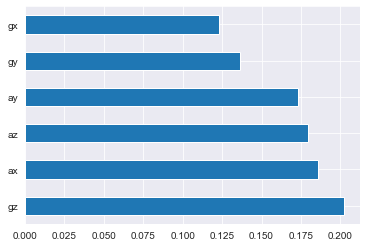

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# 将xy数据转化为树形结构
model = ExtraTreesClassifier()
model.fit(X, y)
# 显示其特征重要性
print(model.feature_importances_)
#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

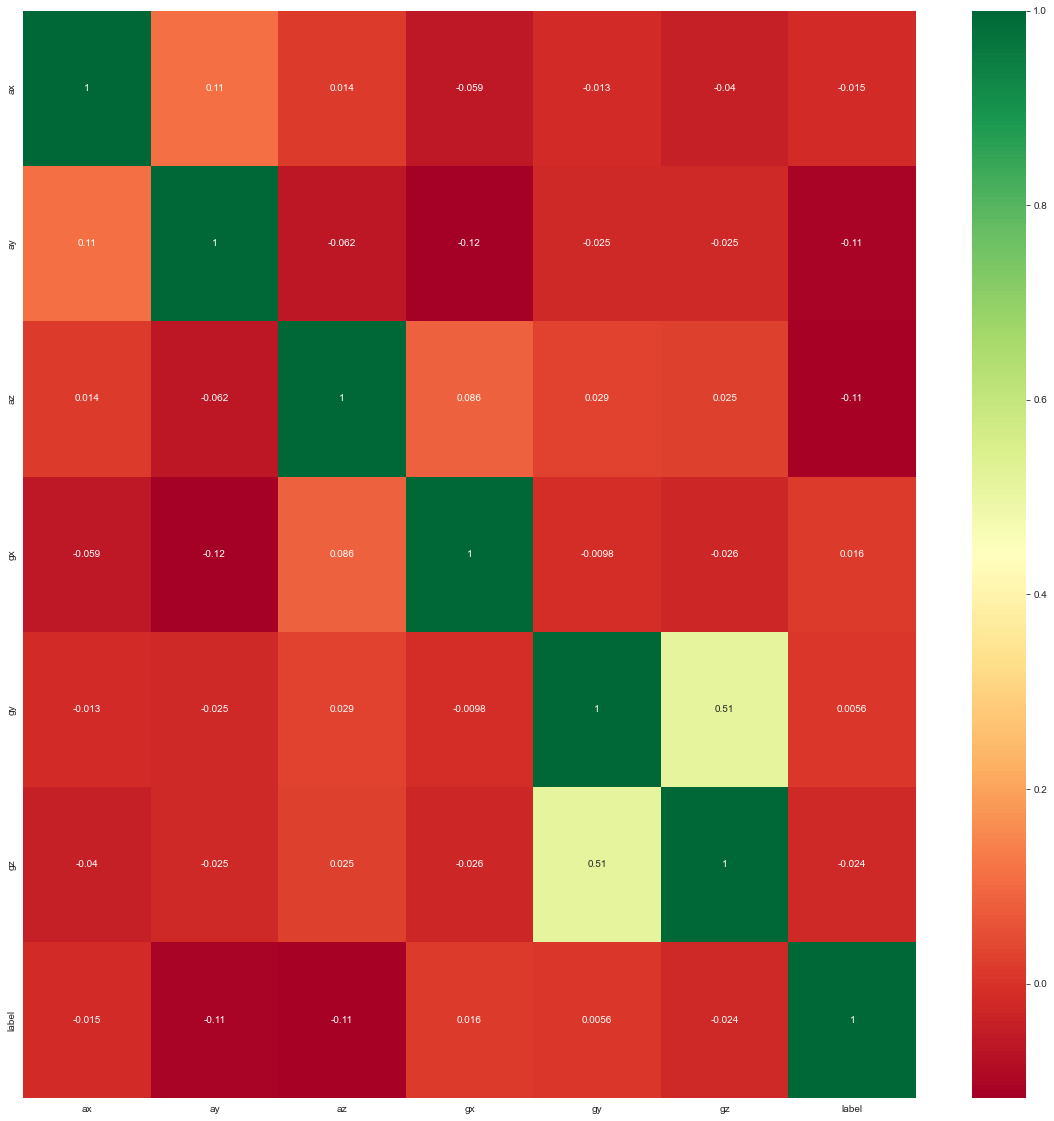

In [7]:
#get correlations of each features in dataset
# 获取6个维度坐标的相关系数
corrmat = df_cor.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
#plot heat map
g = sns.heatmap(df_cor[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [8]:
num_feats = len(feature_name)
X.columns.tolist()

['ax', 'ay', 'az', 'gx', 'gy', 'gz']

In [9]:
def cor_selector(X, y, num_feats):
    cor_list = []
    # feature_name ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    feature_name = X.columns.tolist()

    # calculate the correlation with y for each feature
    # 计算6个参数分别与y的皮尔森系数
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    # replace NaN with 0
    # 如果在cor_list有空的数据就用0来替换
    # [-0.01463550275946156, -0.10801958019976028, -0.11074125802579532, 0.016128046161735972, 0.005552328447956253, -0.02396790664037824]
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    # 根据cor_list的绝对值对X的标签进行排列
    cor_feature = X.iloc[:, np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature_name ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    # cor_feature = ['gy', 'ax', 'gx', 'gz', 'ay', 'az']
    # feature selection? 0 for not select, 1 for select
    # 对于feature_name中的所有元素，如果也在cor_feature中，则返回True，代表都有相关性影响。
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature, cor_list


# 将X,y 维度数量导入函数cor_selector
cor_support, cor_feature, cor_list = cor_selector(X, y, num_feats)
# 取绝对值
cor_val = [abs(x) for x in cor_list]
# 将6个维度名称与每个维度分别对y的相关性影响合并成一个列表然后再写入字典
cor_result = dict(zip(cor_feature, cor_val))
# 只保留有影响的数据。
myDict = {key: val for key, val in cor_result.items() if val > 0}
# 将数据以value值从大到小排列
{k: v for k, v in sorted(myDict.items(), reverse=True, key=lambda item: item[1])}

{'gx': 0.11074125802579532,
 'ax': 0.10801958019976028,
 'az': 0.02396790664037824,
 'gz': 0.016128046161735972,
 'gy': 0.01463550275946156,
 'ay': 0.005552328447956253}

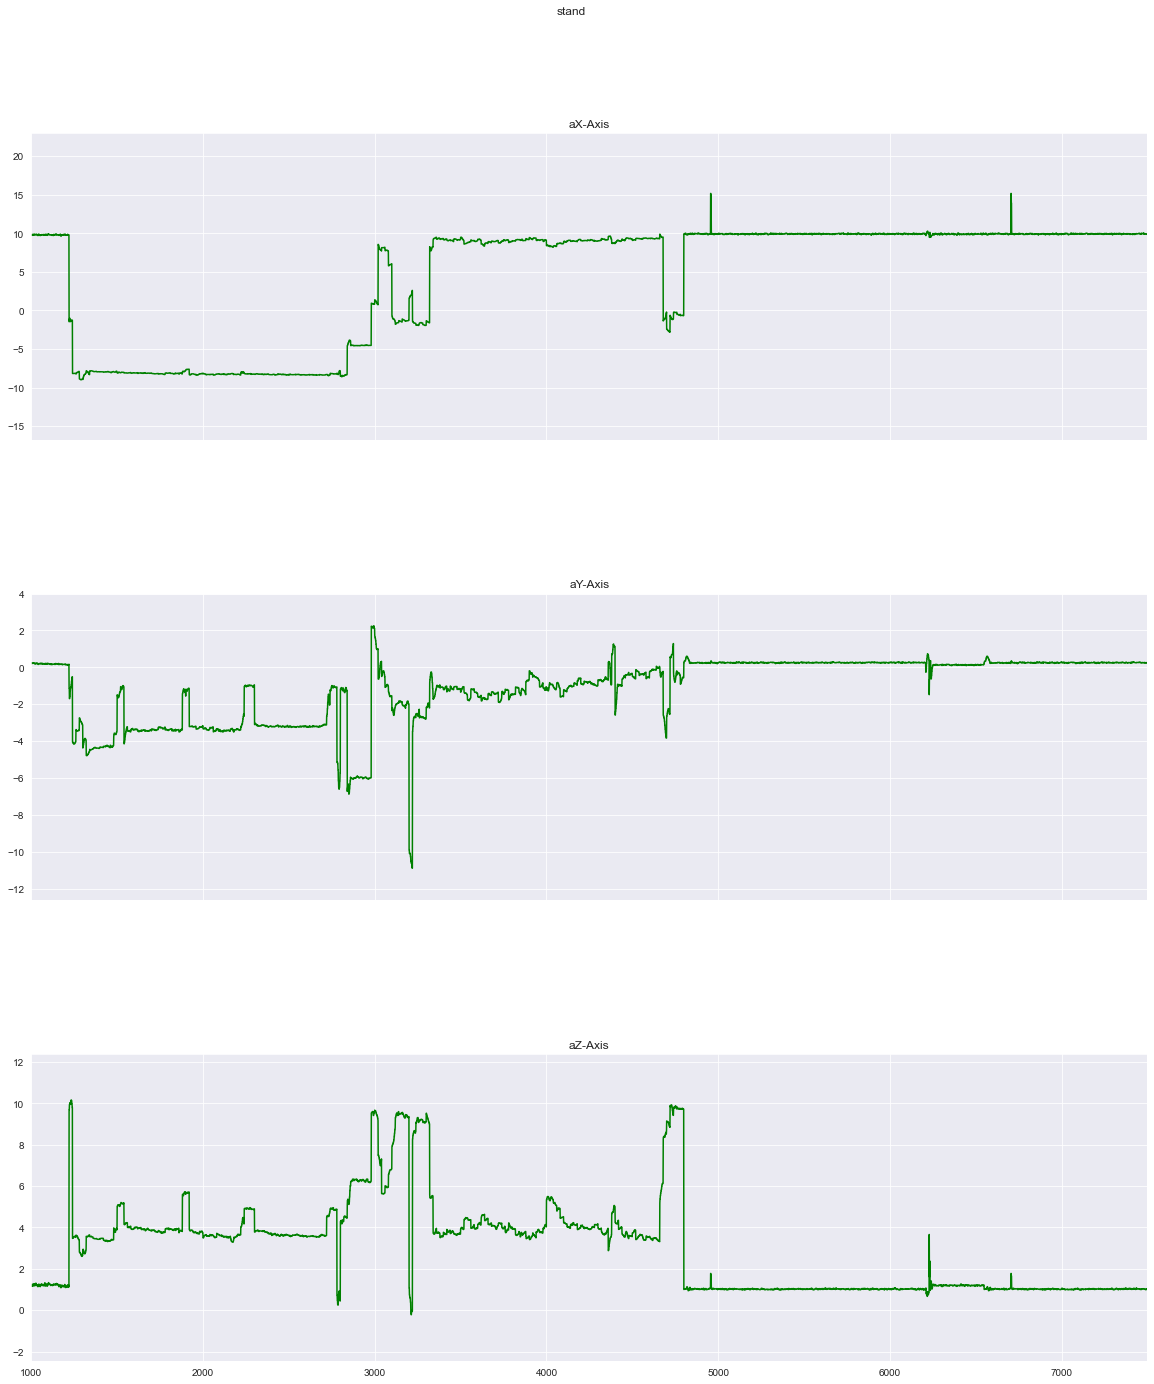

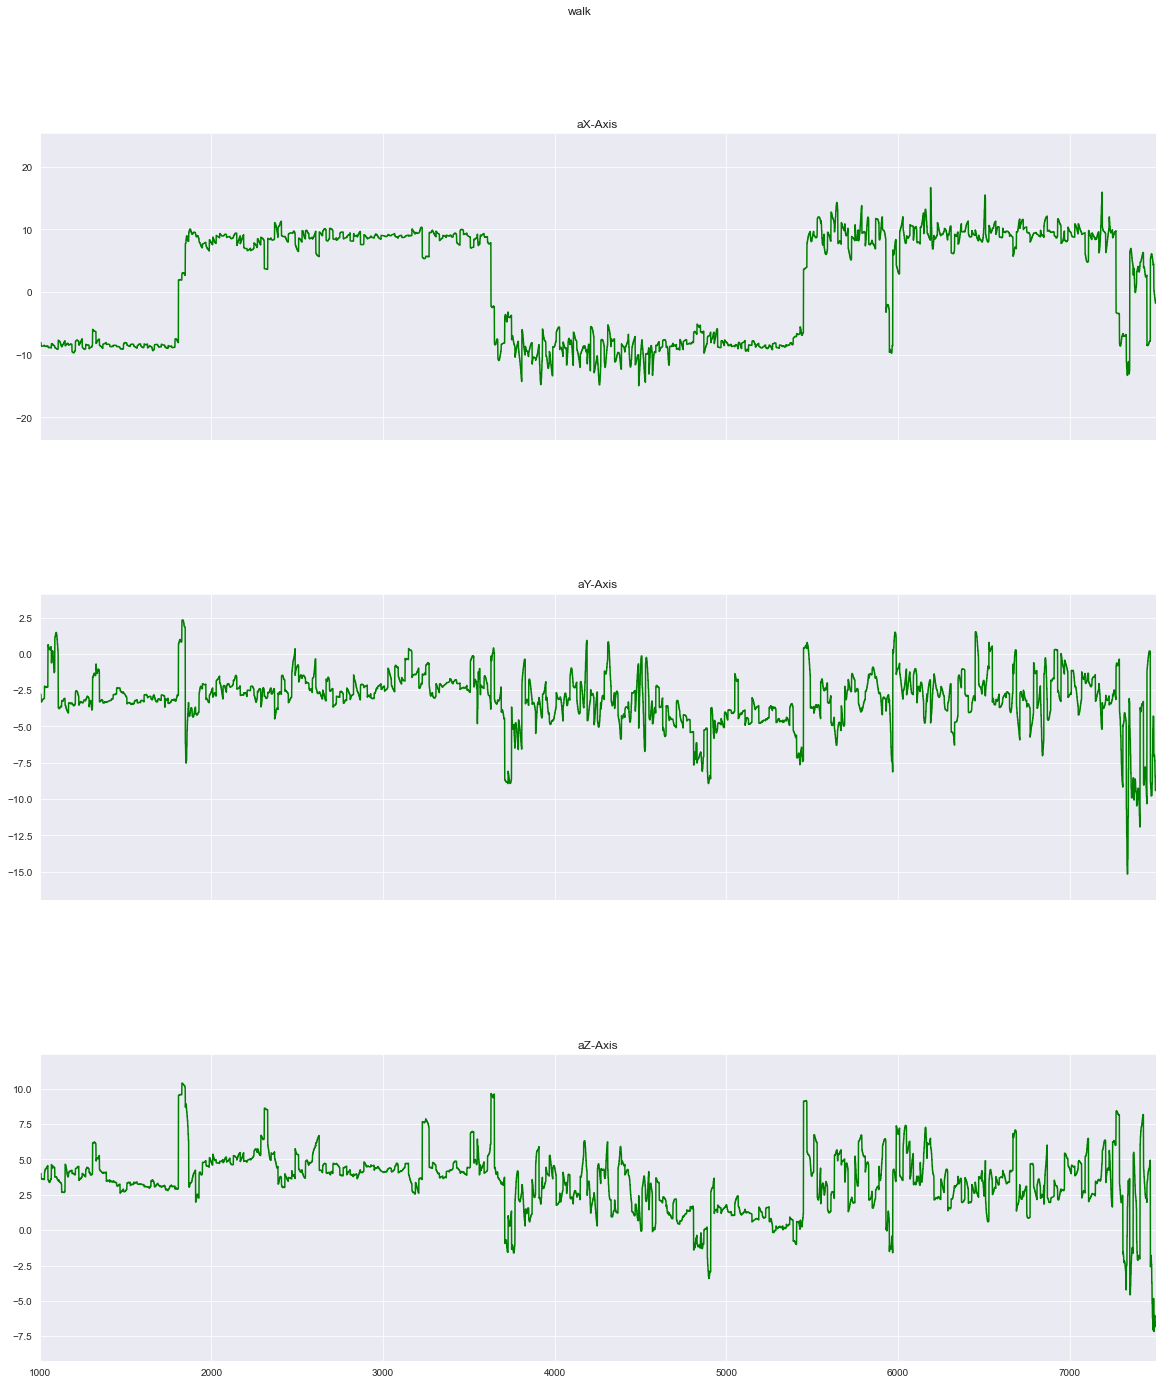

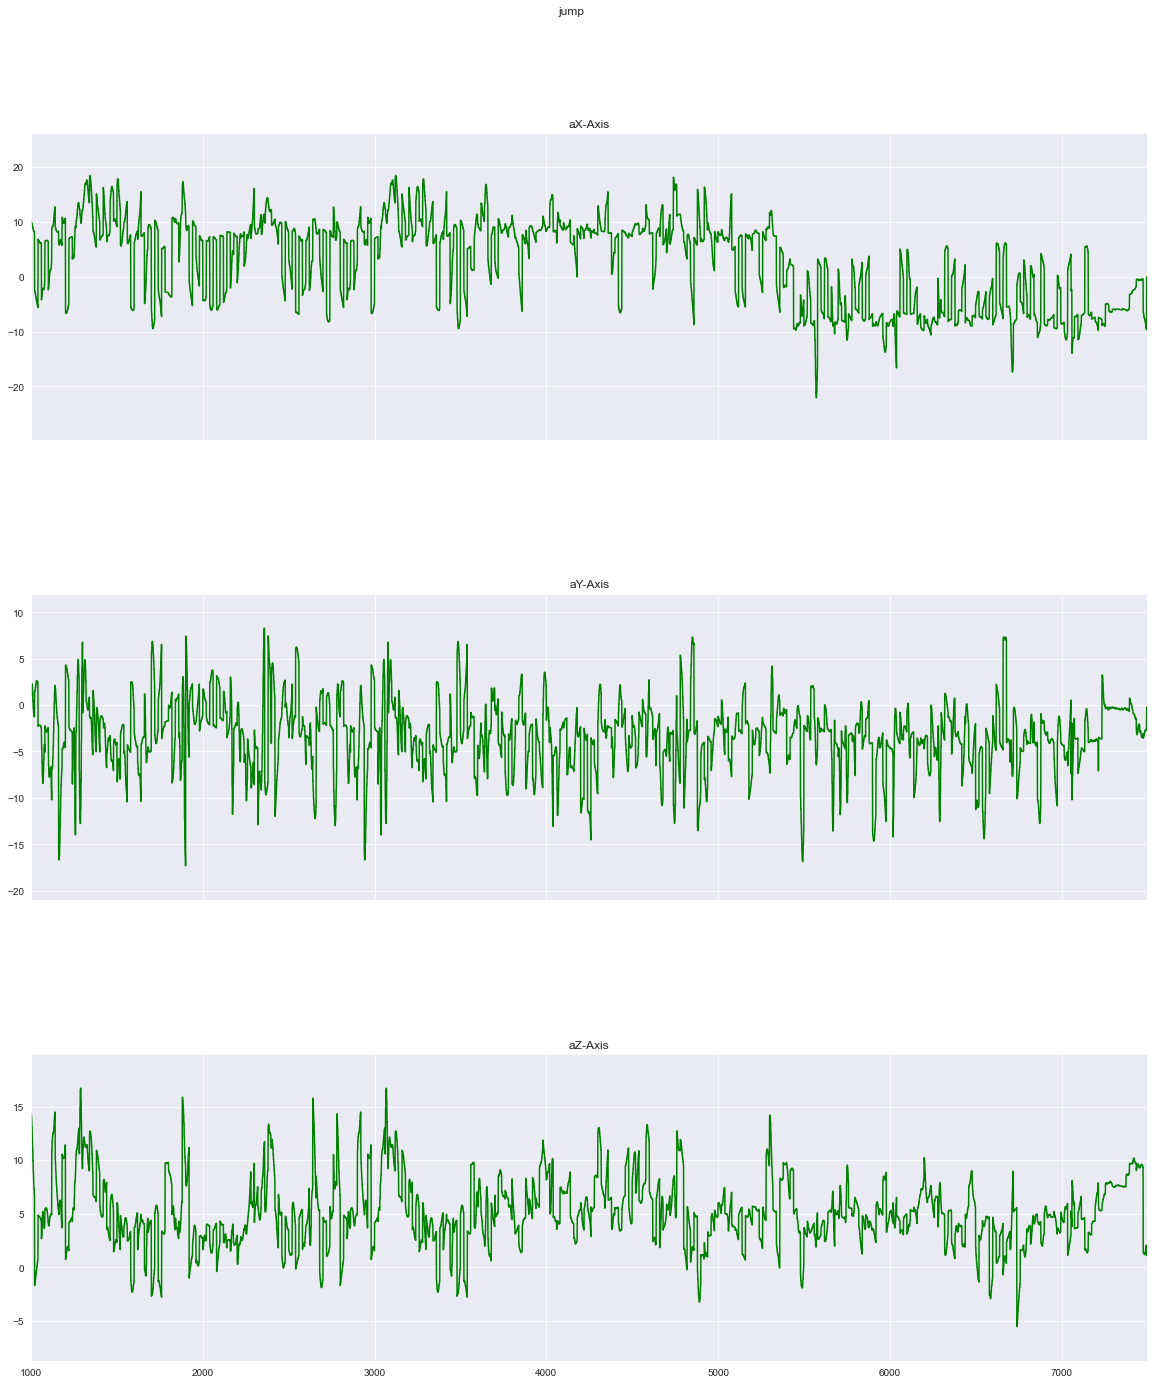

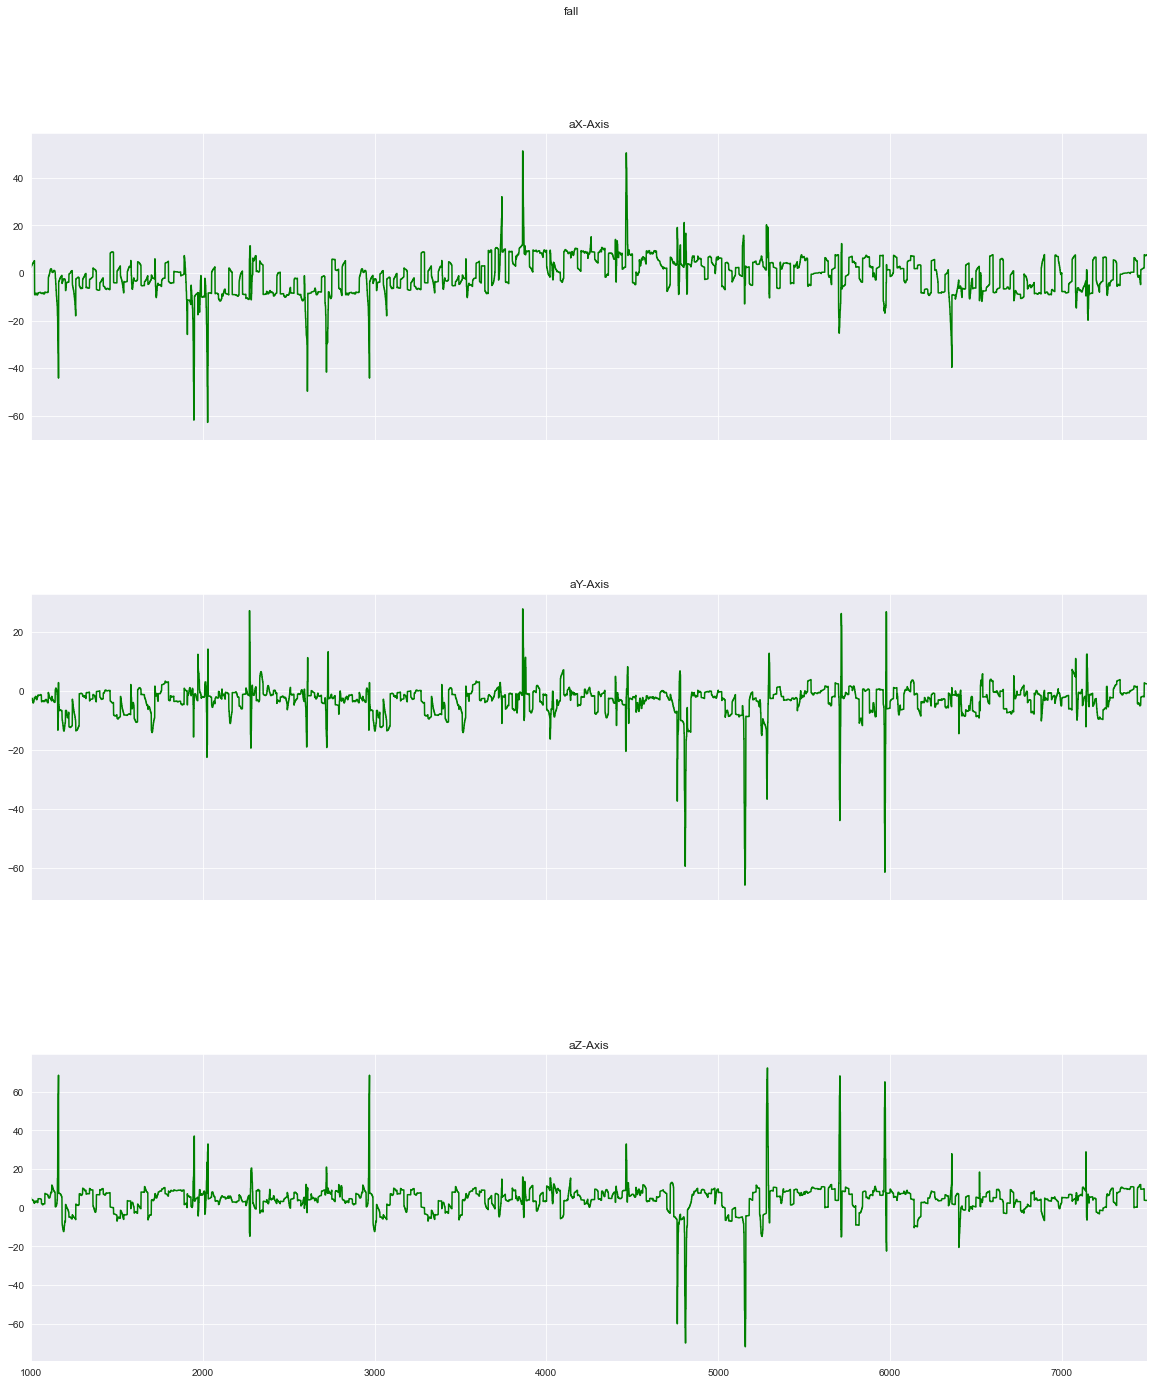

In [10]:
# 深拷贝df文件，防止df文件被修改
df_plot = copy.deepcopy(df)
# 重建索引并且替换df_plot原文件的索引
df_plot.reset_index(inplace=True)
# 根据 四个label出现的频率高低由高到低排序 返回 'stand', 'walk', 'jump', 'fall'
activities = df_plot['label'].value_counts().index


def plot_activity(activity, data):
    #     fig, (ax0, ax1, ax2,ax3,ax4,ax5) = plt.subplots(nrows=6, figsize=(20, 22), sharex=True)
    #   创建一组图形有3个子图，分别为ax0,2,4 。尺寸为 20,22。并且共享x轴坐标
    fig, (ax0, ax2, ax4) = plt.subplots(nrows=3, figsize=(20, 22), sharex='all')
    plot_axis(ax0, data['index'], data['ax'], 'aX-Axis')
    plot_axis(ax2, data['index'], data['ay'], 'aY-Axis')
    plot_axis(ax4, data['index'], data['az'], 'aZ-Axis')
    #     plot_axis(ax1, data['index'], data['gx'], 'gX-Axis')
    #     plot_axis(ax3, data['index'], data['gy'], 'gY-Axis')
    #     plot_axis(ax5, data['index'], data['gz'], 'gZ-Axis')
    # 定义小组标题
    fig.suptitle(activity)
    plt.subplots_adjust(hspace=0.5)

    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    #     ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


Fs = 200
for activity in activities:
    # 选取每个label的6500个数据进行绘图
    data_for_plot = df_plot[(df_plot['label'] == activity)][1000:7500]
    # print(data_for_plot)
    # print(activity)
    plot_activity(activity, data_for_plot)

# Split training and testing data

In [11]:
def train_test_split(label, ratio):
    split_point = int(len(df[df.label == label]) * ratio)
    return (df[df.label == label].iloc[:split_point, :], df[df.label == label].iloc[split_point:, :])


split_ratio = 0.8
train_data = pd.DataFrame([])
test_data = pd.DataFrame([])

for i in range(len(interesting_labels)):
    # 将 训练 /测试数据分为 0.8 / 0.2
    (train, test) = train_test_split(interesting_labels[i], split_ratio)
    train_data = pd.concat([train_data, train])
    test_data = pd.concat([test_data, test])

print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))

train_label = train_data['label'].to_frame()
test_label = test_data['label'].to_frame()
print(len(train_label))

Number of train samples:  51200
Number of test samples:  12800
51200


# Data Segmentation (Sliding Window)

In [12]:
N_TIME_STEPS = 120  #sliding window length
STEP = 20  #Sliding window step size
N_FEATURES = 6


def generate_sequence(x, y, n_time_steps, step):
    # 51200 51200 120 20
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):
        # 获取每组数据第i到i+ nts - 1项
        ax = x['ax'].values[i: i + n_time_steps]
        ay = x['ay'].values[i: i + n_time_steps]
        az = x['az'].values[i: i + n_time_steps]

        #         lx = x['lx'].values[i: i + n_time_steps]
        #         ly = x['ly'].values[i: i + n_time_steps]
        #         lz = x['lz'].values[i: i + n_time_steps]
        gx = x['gx'].values[i: i + n_time_steps]
        gy = x['gy'].values[i: i + n_time_steps]
        gz = x['gz'].values[i: i + n_time_steps]

        # #         mx = x['mx'].values[i: i + n_time_steps]
        # #         my = x['my'].values[i: i + n_time_steps]
        # #         mz = x['mz'].values[i: i + n_time_steps]

        #         ma =  x['ma'].values[i: i + n_time_steps]
        #         mg =  x['mg'].values[i: i + n_time_steps]
        #         ml =  x['ml'].values[i: i + n_time_steps]
        #         mm =  x['mm'].values[i: i + n_time_steps]

        # 返回每组数据最常出现的label，
        label = stats.mode(y['label'][i: i + n_time_steps])[0][0]
        #         segments.append([ax, ay, az, gx, gy, gz, lx, ly, lz, mx, my, mz, ma, mg, ml, mm])
        #         segments.append([ax, ay, az, gx, gy, gz, mx, my, mz])
        segments.append([ax, ay, az, gx, gy, gz])
        labels.append(label)

    return segments, labels


# 将训练数据，标签，N_Time_Steps 与step传入函数.这个函数就是告诉系统，训练的数据为X，对应的y为四种行为。
train_X, train_y = generate_sequence(train_data, train_label, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_data, test_label, N_TIME_STEPS, STEP)

In [13]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    # 将x数据转化为 120个数据为1组 y转化为 四种状态，1234.出现为1，不出现为0
    x_reshaped = np.asarray(x, dtype=np.float32).reshape(-1, n_time_steps)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype=np.float32)
    return x_reshaped, y_reshaped


X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

In [14]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

# Import DL Library

In [15]:
# 导入深度学习相关库文件
from keras.regularizers import l2
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Flatten, Bidirectional
from keras.layers import Attention
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import optimizers
from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

N_CLASSES = 4
N_HIDDEN_UNITS = 8
L2 = 0.00001

# LSTM Model (Training) 

In [1]:
# LSTM model
from keras.backend import clear_session

filepath = 'har_model_lstm_2021.h5'
# 重置keras的所有状态
clear_session()
# 创建一个模型实例
model = Sequential()
# model.add(LSTM(200, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
#          kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
#          bias_regularizer=l2(L2), name="LSTM_1"))
# model.add(LSTM(200,return_sequences=True, name="LSTM_2"))
# model.add(Bidirectional(LSTM(200, input_shape=(N_TIME_STEPS, N_FEATURES), 
#          kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
#          bias_regularizer=l2(L2), name="LSTM_1")))
''''''
# Sequential用于构建序贯模型，它可以由多个网络层进行线性堆叠。
# Bidirectional是双向神经网络结构，Dense就是我们所说的一层全连接神经网络，
# activation是激活函数，dropout是选择层后连接的神经元数，以避免过拟合。
# 添加一个双向神经网络结构的LSTM层，有200个节点
# return sequences：是返回输出序列中的最后一个输出Ture，还是返回完整序列False。
model.add(Bidirectional(LSTM(200, return_sequences=True,
                             # kernel权重矩阵初始化方式 正交？
                             kernel_initializer='orthogonal',
                             # 应用于kernel的权重矩阵的正则化函数。
                             kernel_regularizer=l2(L2),
                             # 施加在循环核上的正则项
                             recurrent_regularizer=l2(L2),
                             # 施加在偏置向量上的正则项
                             bias_regularizer=l2(L2)
                             # 起名为LSTM_1
                             , name="LSTM_1"),
                        # 输入尺寸
                        input_shape=(N_TIME_STEPS, N_FEATURES)))
# model.add(Bidirectional(LSTM(200, return_sequences=True, name="LSTM_1")))
# model.add(SeqSelfAttention(attention_activation='sigmoid'))

# Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
model.add(Flatten(name='Flatten'))
# Dense就是常用的全连接层，所实现的运算是output = activation(dot(input, kernel)+bias)。其中activation是逐元素计算的激活函数，kernel是本层的权值矩阵，bias为偏置向量，只有当use_bias=True才会添加。如果本层的输入数据的维度大于2，则会先被压为与kernel相匹配的大小。
model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_3"))
# 为输入数据施加Dropout。Dropout将在训练过程中每次更新参数时随机断开一定百分比（p）的输入神经元连接，Dropout层用于防止过拟合。
model.add(Dropout(0.2))
# 同上面，只不过尺寸为 N_CLASSES
model.add(Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_4"))

#
model.summary()
# ModelCheckpoint 该回调函数将在每个epoch后保存模型到filepath
checkpoint = ModelCheckpoint(filepath=filepath,
                             # 需要监视的值
                             monitor='val_loss',
                             # 信息展示模式 0或1
                             verbose=1,
                             # 为Ture时，只保存在验证集上性能最好的模型
                             save_best_only=True)
# 当监测值不再改善时，该回调函数将中止训练。
# patience：当early stop被激活（如发现loss相比上一个epoch训练没有下降），则经过patience个epoch后停止训练。
stop = EarlyStopping(monitor='val_loss', patience=5,
                     verbose=0, mode='auto', baseline=None,
                     # 是否从监测量的最佳值的epoch恢复模型权重。如果为 False，则使用在训练的最后一步获得的模型权重。
                     restore_best_weights=False)
# 当评价指标不在提升时，减少学习率。
reduce = ReduceLROnPlateau(monitor='val_loss',
                           # factor：每次减少学习率的因子，学习率将以lr = lr*factor的形式被减少
                           factor=0.5,
                           # patience：当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
                           patience=2,
                           verbose=1)
callbacks = [checkpoint, stop]
# 内置Adam优化器，学习效率为0.001
opt = tf.keras.optimizers.Adam(0.001)
# 编译模型以提供训练，类似于初始化TF。
model.compile(optimizer=opt,  # 优化器
              # 损失函数或目标函数
              loss='categorical_crossentropy',
              # 评估模型和测试性能的指标
              metrics=['accuracy'])

BATCH_SIZE = 64
N_EPOCHS = 300
print(X_train.shape)
print(y_train.shape)
# fit 训练epochs轮。 x为输入，y为标签。
lstm = model.fit(X_train, y_train,
                 # batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步。
                 batch_size=BATCH_SIZE,
                 # shuffle：布尔值或字符串，一般为布尔值，表示是否在训练过程中随机打乱输入样本的顺序。若为字符串“batch”，则是用来处理HDF5数据的特殊情况，它将在batch内部将数据打乱。
                 shuffle=True, epochs=N_EPOCHS,
                 # 模型训练期间在某些点调用的实用程序
                 callbacks=callbacks,
                 # 形式为（X，y）的tuple，是指定的验证集。此参数将覆盖validation_spilt。
                 validation_data=(X_test, y_test))

NameError: name 'Sequential' is not defined

In [ ]:
# 92 0.2288 1 layer lstm 256
# 93 0.2472 1 layer lstm 200
# 91 0.2273 2 layer lstm 200
# 91 0.2337 1 layer lstm 128
# 90 0.2886 2 layer lstm 256
# 90 0.2610 1 bilsmt 128
# 94 0.2053 1 bilstm 200
# 90 0.2523 2 bilstm 200
# 92 0.2376 1 bilstm 265

In [17]:
model = load_model(filepath)

In [18]:
# use LSTM model to predict
# predict：按batch获得输入数据对应的输出
y_pred_ohe = model.predict(X_test)
# 返回axis=1轴的最大值的索引
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
# 计算混淆矩阵以评估分类的准确性。
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(y_true_labels)
LABELS = ['Standing', 'Walking', 'Falling', 'Jumping']
# 绘图
plt.figure(figsize=(8, 6))
# 改变绘图背景颜色
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# 混淆矩阵画热力图 annot: 默认为False，为True的话，会在格子上显示数字。
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")
plt.ylabel('True label')
# plt.ylim((16,14))
plt.xlabel('Predicted label')
plt.show();



ValueError: in user code:

    File "C:\Users\chen\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\chen\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\chen\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\chen\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "C:\Users\chen\miniconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\chen\miniconda3\envs\py310\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "bidirectional" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 120)
    
    Call arguments received by layer "sequential" (type Sequential):
      • inputs=tf.Tensor(shape=(None, 120), dtype=float32)
      • training=False
      • mask=None


In [19]:
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

NameError: name 'lstm' is not defined

# Save the model into .pb file

In [ ]:
# N_TIME_STEPS = 100 #sliding window length
# STEP = 20 #Sliding window step size
# N_FEATURES = 8


In [ ]:
# Save LSTM model

output_node_name = "Dense_2/Softmax"
MODEL_LSTM = str(N_TIME_STEPS) + "_" + str(STEP) + "_" + str(N_FEATURES) + "_" + str(N_CLASSES) + "_nomagnew"

tf.train.write_graph(K.get_session().graph_def, './models/LSTM/', MODEL_LSTM + '_graph.pbtxt')
saver = tf.train.Saver()
saver.save(K.get_session(), './models/LSTM/' + MODEL_LSTM + '.chkp')

freeze_graph.freeze_graph('./models/LSTM/' + MODEL_LSTM + '_graph.pbtxt', None, False,
                          './models/LSTM/' + MODEL_LSTM + '.chkp', output_node_name, "save/restore_all", "save/Const:0",
                          './models/LSTM/' + MODEL_LSTM + '.pb', True, "")



# CNN Model 

In [ ]:
# 导入相关库
from keras.backend import clear_session

clear_session()
# CNN model
# 初始化模型
model = Sequential()
# Conv2D：二维卷积层，即对图像的空域卷积。该层对二维输入进行滑动窗卷积。
# N_HIDDEN_UNITS * 3：卷积核的数目（即输出的维度）
model.add(Conv2D(N_HIDDEN_UNITS * 3,
                 kernel_size=3,
                 # 输入形状
                 input_shape=(X_train.shape[1], X_train.shape[2], 1),
                 # padding：补0策略，为“valid”, “same” 。“valid”代表只进行有效的卷积，即对边界数据不处理。“same”代表保留边界处的卷积结果，通常会导致输出shape与输入shape相同。
                 padding='same',
                 # 激活函数ReLU函数。
                 activation='relu', name="Conv2D_Layer1"))
# 后面的和LTSM的类似。不外乎参数不一样。
model.add(Conv2D(N_HIDDEN_UNITS * 2, kernel_size=3, padding='same', activation='relu', name="Conv2D_Layer2"))

model.add(Conv2D(N_HIDDEN_UNITS, kernel_size=3, padding='same', activation='relu', name="Conv2D_Layer3"))

model.add(Flatten(name="Flatten_Layer"))

model.add(Dense(N_CLASSES, activation='softmax', name="CNN_output"))

model.summary()

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

BATCH_SIZE = 24
N_EPOCHS = 100

cnn = model.fit(np.expand_dims(X_train, axis=-1), y_train,
                batch_size=BATCH_SIZE, epochs=N_EPOCHS,
                validation_data=(np.expand_dims(X_test, axis=-1), y_test))
print(model_m.summary())

In [ ]:
model.save("model_har.h5")

In [ ]:
y_pred_ohe = model.predict(np.expand_dims(X_test, axis=-1))
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(y_true_labels)
LABELS = ['Standing', 'Walking', 'Falling', 'Jumping']

#y_pred_ohe = model.predict(np.expand_dims(X_test, axis=-1))
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)
#y_true_labels = np.argmax(y_test, axis=1)
#confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
# print(y_true_labels)
#LABELS = [ 'standing', 'walking','Falling','Jumping']

plt.figure(figsize=(8, 6))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("CNN Result Confusion matrix")
plt.ylabel('True label')
# plt.ylim((16,14))
plt.xlabel('Predicted label')
plt.show();
#plt.figure(figsize=(8, 6))
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)
#sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
#plt.title("CNN Result Confusion Matrix")
#plt.ylabel('True label')
#plt.ylim((16,14))
#plt.xlabel('Predicted label')
#plt.show();

In [ ]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

# Save model to .pb file

In [ ]:
# # Save CNN model
# output_node_name = "CNN_output/Softmax"
# MODEL_NAME = "2020_02_09_CNN"

# tf.train.write_graph(K.get_session().graph_def, './models/CNN/', \
#         MODEL_NAME + '_graph.pbtxt')
# saver = tf.train.Saver()
# saver.save(K.get_session(), './models/CNN/' + MODEL_NAME + '.chkp')

# freeze_graph.freeze_graph('./models/CNN/' + MODEL_NAME + '_graph.pbtxt', None, \
#     False, './models/CNN/' + MODEL_NAME + '.chkp', output_node_name, \
#     "save/restore_all", "save/Const:0", \
#     './models/CNN/' + MODEL_NAME + '.pb', True, "")

# Convert .pb to tflite

In [ ]:
# import tensorflow as tf
# # model_dir='./models/CNN/2020_02_09_CNN.pb'
# model_dir='model_har.h5'

# input_arrays = ['Conv2D_Layer1_input']
# output_arrays = ['CNN_output/Softmax']

# tfc = tf.lite.TFLiteConverter.from_keras_model_file(model_dir)
# # converter =  tfc.from_keras_model_file(model_dir, input_arrays, output_arrays)

# tflite_model = tfc.convert()
# open("CNN_model.tflite","wb").write(tflite_model)

# Make sure the model output and input name

In [ ]:
# import tensorflow as tf
# gf = tf.GraphDef()   
# m_file = open(r"D:\Human Activity Recognition\Training\models\LSTM\100_12_walk_stand.pb",'rb')
# gf.ParseFromString(m_file.read())

# with open('somefile.txt', 'a') as the_file:
#     for n in gf.node:
#         the_file.write(n.name+'\n')

# file = open('somefile.txt','r')
# data = file.readlines()
# print ("output name = ")
# print (data[len(data)-1])

# print ("Input name = ")
# file.seek ( 0 )
# print (file.readline())